In [1]:
import pandas as pd
import numpy as np
import joblib
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import yaml
import os
import logging
from contextlib import nullcontext
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

mlflow_tracking_uri = 'http://localhost:5555'  # Optional: e.g., 'http://localhost:5555'

In [2]:
# Load dataset
data_path = '../data/processed/data_scientists_features.csv'  # Update path if needed
data = pd.read_csv(data_path)

# One-hot encode categorical features since RFE doesn't support category dtype
data = pd.get_dummies(data, columns=['location', 'condition'], drop_first=True)

X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor

# Use XGBoost for RFE to stay consistent
# With one-hot encoding, we no longer need the special XGBoost parameters
xgb_model = XGBRegressor(objective='reg:squarederror')

# RFE
# The first xgb_model.fit() was redundant because RFE fits the model internally.
rfe_selector = RFE(estimator=xgb_model, n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
rfe_selected_features = X.columns[rfe_selector.support_]
rfe_ignored_features = X.columns[~rfe_selector.support_]

print("✅ Top 10 Selected Features by RFE:")
for feature in rfe_selected_features:
    print(f" - {feature}")

print("\n❌ Features Ignored by RFE:")
for feature in rfe_ignored_features:
    print(f" - {feature}")

# Store for config
selected_features_dict = {
    'rfe': list(rfe_selected_features)
}

# Filter datasets to use only selected features for experimentation
X_train = X_train[rfe_selected_features]
X_test = X_test[rfe_selected_features]


✅ Top 10 Selected Features by RFE:
 - sqft
 - bathrooms
 - year_built
 - price_per_sqft
 - bed_bath_ratio
 - location_Suburb
 - location_Urban
 - condition_Fair
 - condition_Good
 - condition_Poor

❌ Features Ignored by RFE:
 - bedrooms
 - house_age
 - location_Mountain
 - location_Rural
 - location_Waterfront


In [4]:
# Optional MLflow setup
if mlflow_tracking_uri:
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    mlflow.set_experiment("House Price Prediction Experiment")


2025/08/25 10:12:22 INFO mlflow.tracking.fluent: Experiment with name 'House Price Prediction Experiment' does not exist. Creating a new experiment.


In [5]:
# Define models and hyperparameter grids
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror')
}

model_grids = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [100, 150],
        'max_depth': [None, 10, 20]
    },
    'GradientBoosting': {
        'n_estimators': [100, 250],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    }
}


In [6]:
def evaluate_model_with_gridsearch(name, model, grid, X_train, y_train, X_test, y_test):
    if grid:
        clf = GridSearchCV(model, grid, cv=3, scoring='r2', n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_
        best_params = clf.best_params_
    else:
        model.fit(X_train, y_train)
        best_model = model
        best_params = model.get_params()

    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'model': best_model,
        'params': best_params
    }

print("MLflow tracking URI:", mlflow_tracking_uri)


MLflow tracking URI: http://localhost:5555


In [7]:
results = {}

with mlflow.start_run(run_name="model_comparison") if mlflow_tracking_uri else nullcontext():
    for name, model in models.items():
        logger.info(f"Training {name}...")
        with mlflow.start_run(run_name=name, nested=True) if mlflow_tracking_uri else nullcontext():
            evaluation = evaluate_model_with_gridsearch(name, model, model_grids[name], X_train, y_train, X_test, y_test)
            results[name] = evaluation

            if mlflow_tracking_uri:
                mlflow.log_params(evaluation['params'])
                mlflow.log_metrics({
                    'mae': evaluation['mae'],
                    'mse': evaluation['mse'],
                    'rmse': evaluation['rmse'],
                    'r2': evaluation['r2']
                })
                mlflow.sklearn.log_model(evaluation['model'], artifact_path=name.lower().replace(" ", "_"))
            
            print(f"{name} R2: {evaluation['r2']:.4f}, RMSE: {evaluation['rmse']:.2f}")


INFO:root:Training LinearRegression...
/Users/arashshahmansoori/Desktop/all projects/house-price-predictor/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/08/25 10:12:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training RandomForest...


LinearRegression R2: 0.9879, RMSE: 30240.17


/Users/arashshahmansoori/Desktop/all projects/house-price-predictor/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/08/25 10:12:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training GradientBoosting...


RandomForest R2: 0.9867, RMSE: 31658.47


/Users/arashshahmansoori/Desktop/all projects/house-price-predictor/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/08/25 10:12:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training XGBoost...


GradientBoosting R2: 0.9746, RMSE: 43796.92


/Users/arashshahmansoori/Desktop/all projects/house-price-predictor/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/08/25 10:13:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


XGBoost R2: 0.9899, RMSE: 27666.96


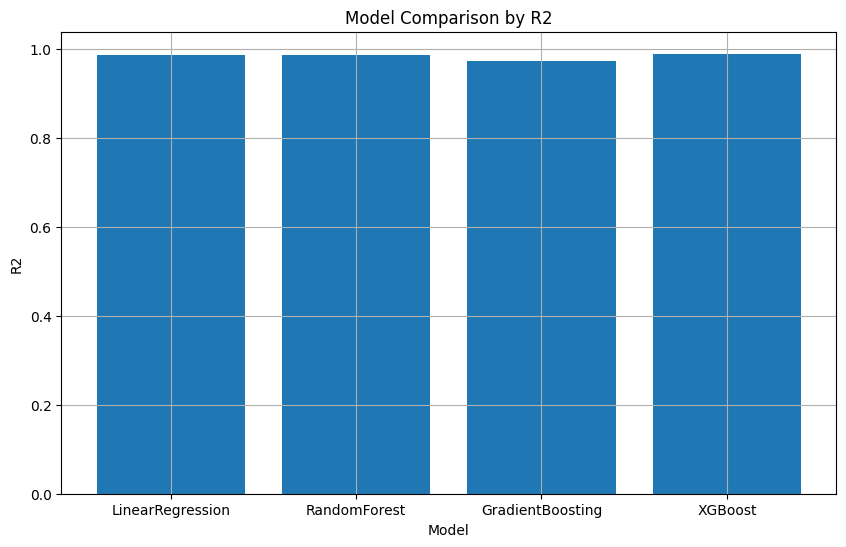

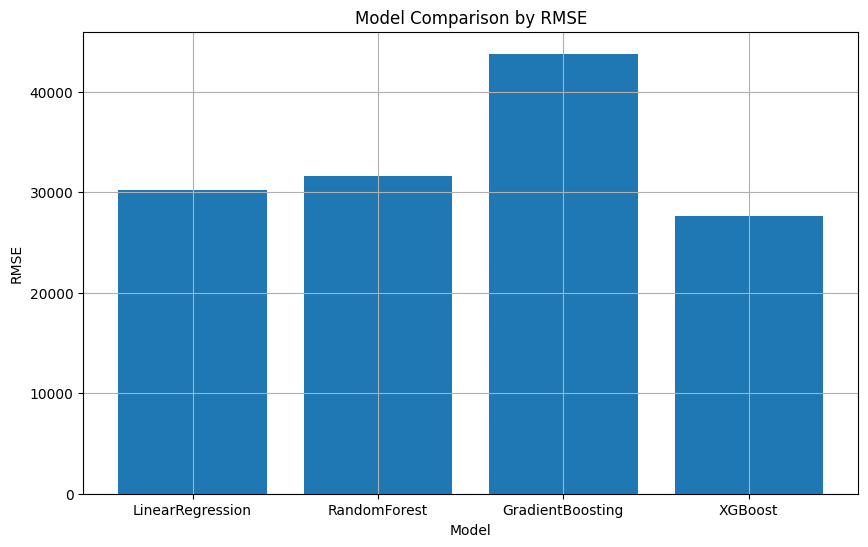

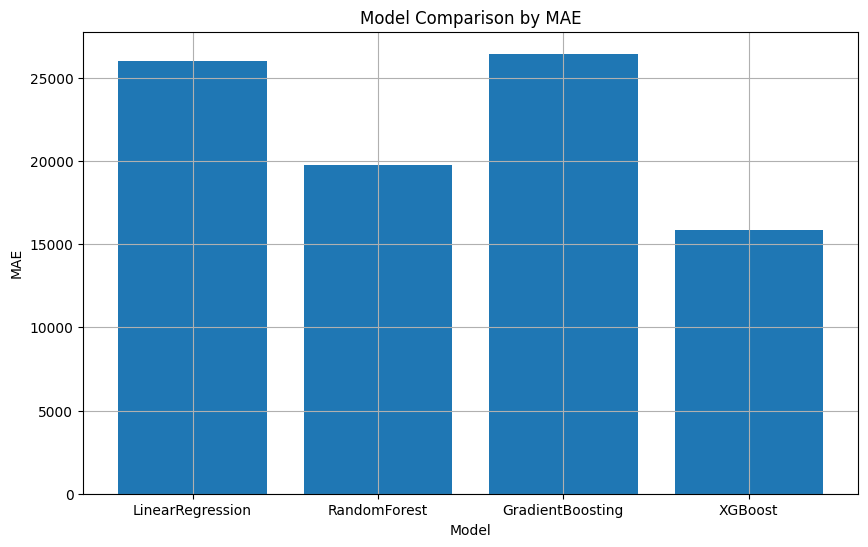

In [8]:
def plot_model_metrics(results, metric='r2'):
    names = list(results.keys())
    values = [results[name][metric] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, values)
    plt.title(f'Model Comparison by {metric.upper()}')
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

# Example usage:
plot_model_metrics(results, metric='r2')
plot_model_metrics(results, metric='rmse')
plot_model_metrics(results, metric='mae')



In [9]:
import yaml

# Save model config with selected features 
# Display information about the best model
best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
best_params = best_model.get_params()
best_r2 = float(results[best_model_name]['r2'])
best_mae = float(results[best_model_name]['mae'])
best_rmse = float(results[best_model_name]['rmse'])

print(f"🏆 Best Model: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   MAE: {best_mae:.2f}")
print(f"   RMSE: {best_rmse:.2f}")

model_config = {
    'model': {
        'name': 'house_price_model',
        'best_model': best_model_name,
        'parameters': best_params,
        'r2_score': best_r2,
        'mae': best_mae,
        'target_variable': 'price',
        'feature_sets': selected_features_dict
    }
}

config_path = '../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(model_config, f)

print(f"Saved model config to {config_path}")


🏆 Best Model: XGBoost
   R² Score: 0.9899
   MAE: 15827.83
   RMSE: 27666.96
Saved model config to ../configs/model_config.yaml
